In [30]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 25.5 MB/s eta 0:00:00


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import optuna

In [4]:
series = pd.read_csv("series_total.csv")
weekly_cases = pd.read_csv("weekly_cases.csv")
# 1. Converter a coluna de data para datetime
weekly_cases["Epi_Date"] = pd.to_datetime(weekly_cases["Epi_Date"])

# 2. Ordenar por data, se necessário
weekly_cases = weekly_cases.sort_values("Epi_Date")
weekly_cases.columns = ["Data", "Ano", "Semana", "Numero de casos"]

In [5]:
weekly_cases = weekly_cases.sort_values("Data")
series = weekly_cases[["Data", "Numero de casos"]].copy()
series.set_index("Data", inplace=True)

### Train test split

In [21]:
# prompt: faça a divisão em treino e teste da variavel series

# Split data into training and testing sets
train_size = int(len(series) * 0.85)  # 80% for training, 20% for testing
train_data, test_data = series[0:train_size], series[train_size:len(series)]

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

Training data size: 198
Testing data size: 35


In [34]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Normalizar os valores
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(series)

# Criar janelas (sequência -> próxima previsão)
def create_dataset(data, window_size=32):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Tamanho da janela de observação (ex: 12 semanas)
window_size = 32
X, y = create_dataset(scaled_values, window_size=window_size)

# Redimensionar X para LSTM: [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

In [23]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Treinar
model.fit(X, y, epochs=250, verbose=1)

Epoch 1/250


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0096
Epoch 2/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027
Epoch 3/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0023
Epoch 4/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0030
Epoch 5/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0020
Epoch 6/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0032
Epoch 7/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0017
Epoch 8/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0024
Epoch 9/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0020
Epoch 10/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0032
Epoch 11/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0024
Epoch 12/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0024
Epoch 13/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0019
Epoch 14/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0026
Epoch 15/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0030
Epoch 16/250
6/6 ━━━━━━━━━━━━━━

In [24]:
# Última janela observada (início da previsão)
last_window = scaled_values[-window_size:].reshape(1, window_size, 1)

# Previsão recursiva
future_predictions = []
n_future = 52

for _ in range(n_future):
    next_pred = model.predict(last_window, verbose=0)
    future_predictions.append(next_pred[0, 0])

    # Atualizar a janela com a nova previsão
    last_window = np.append(last_window[:, 1:, :], [[[next_pred[0, 0]]]], axis=1)

# Inverter a escala
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

In [28]:
last_date = train_data.index[-2]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=52, freq='W')

df_future = pd.DataFrame({
    'Data': future_dates,
    'Previsao de casos': future_predictions
})

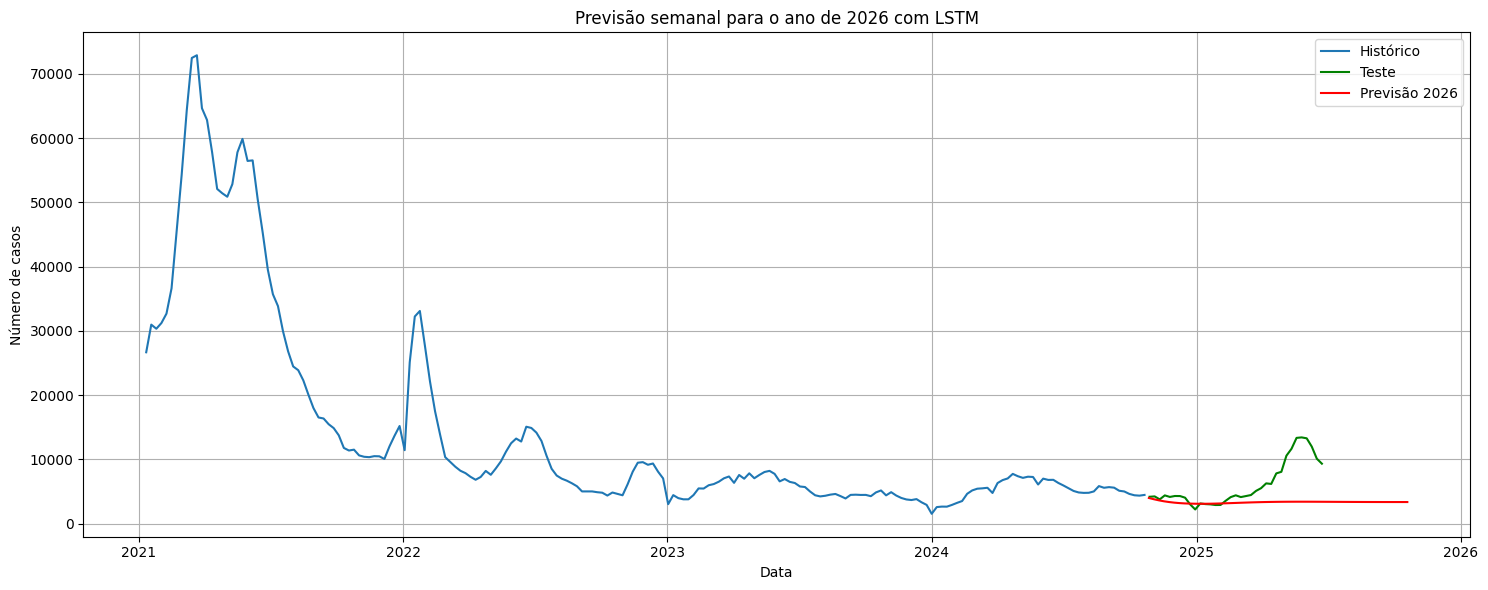

In [29]:
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data["Numero de casos"], label="Histórico")
plt.plot(test_data.index, test_data["Numero de casos"], label="Teste", color="green")
plt.plot(df_future["Data"], df_future["Previsao de casos"], label="Previsão 2026", color="red")
plt.xlabel("Data")
plt.ylabel("Número de casos")
plt.title("Previsão semanal para o ano de 2026 com LSTM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
def mape(y_true, y_pred):
    mask = y_true != 0
    y_true, y_pred = y_true[mask], y_pred[mask]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### using optuna to optimize hyperparameters

In [33]:
def create_dataset(data, window_size=32):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [58]:
def objective(trial):
    # Hiperparâmetros otimizáveis
    window_size = trial.suggest_int("window_size", 8, 64)
    n_units = trial.suggest_int("n_units", 16, 128)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    epochs = 200

    # Normalizar e dividir os dados
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(series[["Numero de casos"]])

    X, y = create_dataset(scaled_values, window_size)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Separar treino/validação
    split_idx = int(len(X) * 0.8)
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]

    # Criar modelo LSTM
    model = Sequential()
    model.add(LSTM(n_units, activation=activation, input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")

    # Treinar modelo
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Prever na validação
    y_pred = model.predict(X_val, verbose=0).flatten()
    y_val = y_val.flatten()

    return mape(y_val, y_pred)

In [59]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Melhores hiperparâmetros encontrados:")
print(study.best_params)

[I 2025-07-11 08:33:59,141] A new study created in memory with name: no-name-59a7123d-7f94-410b-9640-64ddb0953a9d
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-07-11 08:35:02,280] Trial 0 finished with value: 22.22639350540113 and parameters: {'window_size': 41, 'n_units': 110, 'learning_rate': 0.008888621614646633, 'activation': 'tanh', 'batch_size': 16}. Best is trial 0 with value: 22.22639350540113.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-07-11 08:36:02,250] Trial 1 finished with value: 25.

Melhores hiperparâmetros encontrados:
{'window_size': 56, 'n_units': 109, 'learning_rate': 0.002640683104946145, 'activation': 'tanh', 'batch_size': 8}


In [60]:
study.best_params

{'window_size': 56,
 'n_units': 109,
 'learning_rate': 0.002640683104946145,
 'activation': 'tanh',
 'batch_size': 8}

In [61]:
best_params = study.best_params
window_size = best_params["window_size"]

# Recriar dados e modelo final
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(train_data[["Numero de casos"]])
X, y = create_dataset(scaled_values, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(best_params["n_units"], activation=best_params["activation"], input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

model.fit(X, y, epochs=100, batch_size=best_params["batch_size"], verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0023
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.8042e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 6.7544e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.9594e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.1807e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.1757e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.0623e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.6820e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.7668e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.5814e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.6992e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.1472e-04
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.4919e-04
Epoch 14/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.0864e-04
Epoch 15/100
18/1

In [62]:
last_window = scaled_values[-window_size:].reshape(1, window_size, 1)
future_predictions = []

for _ in range(52):  # 52 semanas
    pred = model.predict(last_window, verbose=0)
    future_predictions.append(pred[0, 0])
    last_window = np.append(last_window[:, 1:, :], [[[pred[0, 0]]]], axis=1)

# Inverter a escala
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()


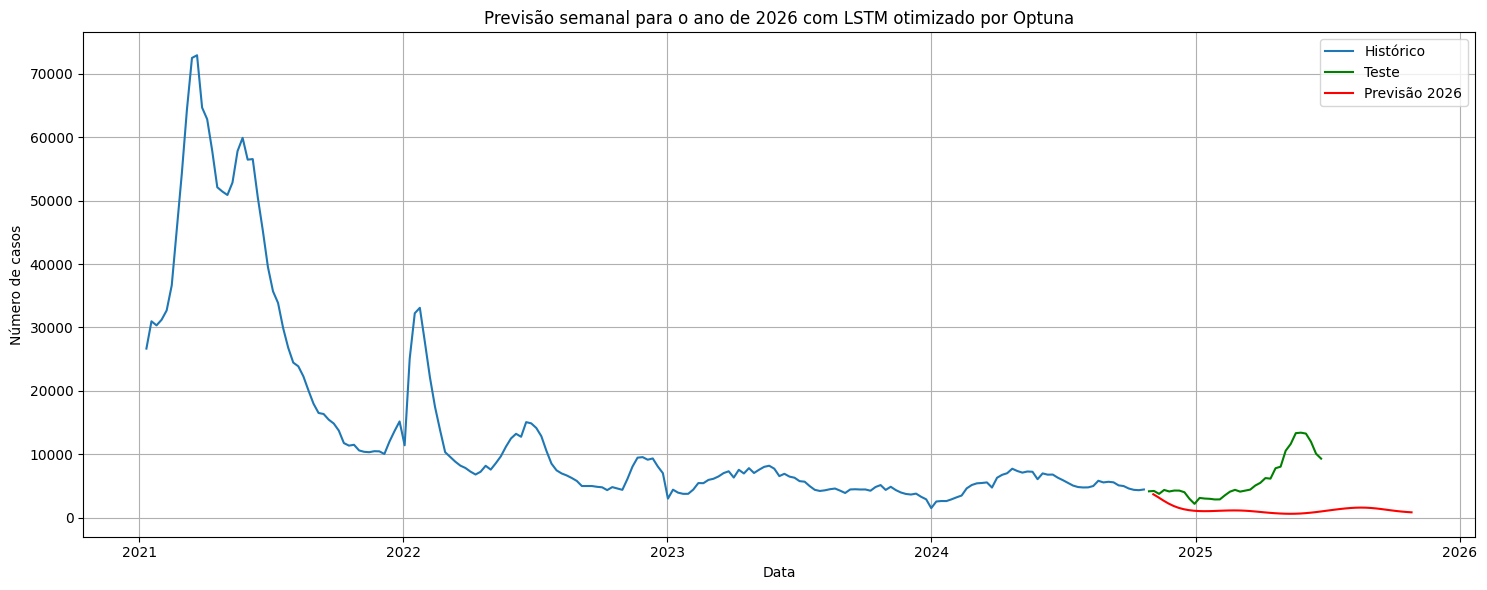

In [63]:
future_dates = pd.date_range(start=train_data.index[-1] + pd.Timedelta(weeks=1), periods=52, freq='W')
df_future = pd.DataFrame({'Data': future_dates, 'Previsao de casos': future_predictions})

plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data["Numero de casos"], label="Histórico")
plt.plot(test_data.index, test_data["Numero de casos"], label="Teste", color="green")
plt.plot(df_future["Data"], df_future["Previsao de casos"], label="Previsão 2026", color="red")
plt.xlabel("Data")
plt.ylabel("Número de casos")
plt.title("Previsão semanal para o ano de 2026 com LSTM otimizado por Optuna")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
# Certifique-se de que as datas estão ordenadas
test_df = test_data.reset_index().sort_values("Data")
future_df = df_future.sort_values("Data")

# Merge com tolerância de 7 dias (semana)
df_eval = pd.merge_asof(
    test_df, future_df,
    on="Data",
    tolerance=pd.Timedelta("7D"),
    direction="nearest"
)

# Remover linhas onde não houve correspondência
df_eval = df_eval.dropna()

# Calcular MAPE se houver dados suficientes
if not df_eval.empty:
    mape_val = mape(df_eval["Numero de casos"].values, df_eval["Previsao de casos"].values)
else:
    mape_val = float("nan")

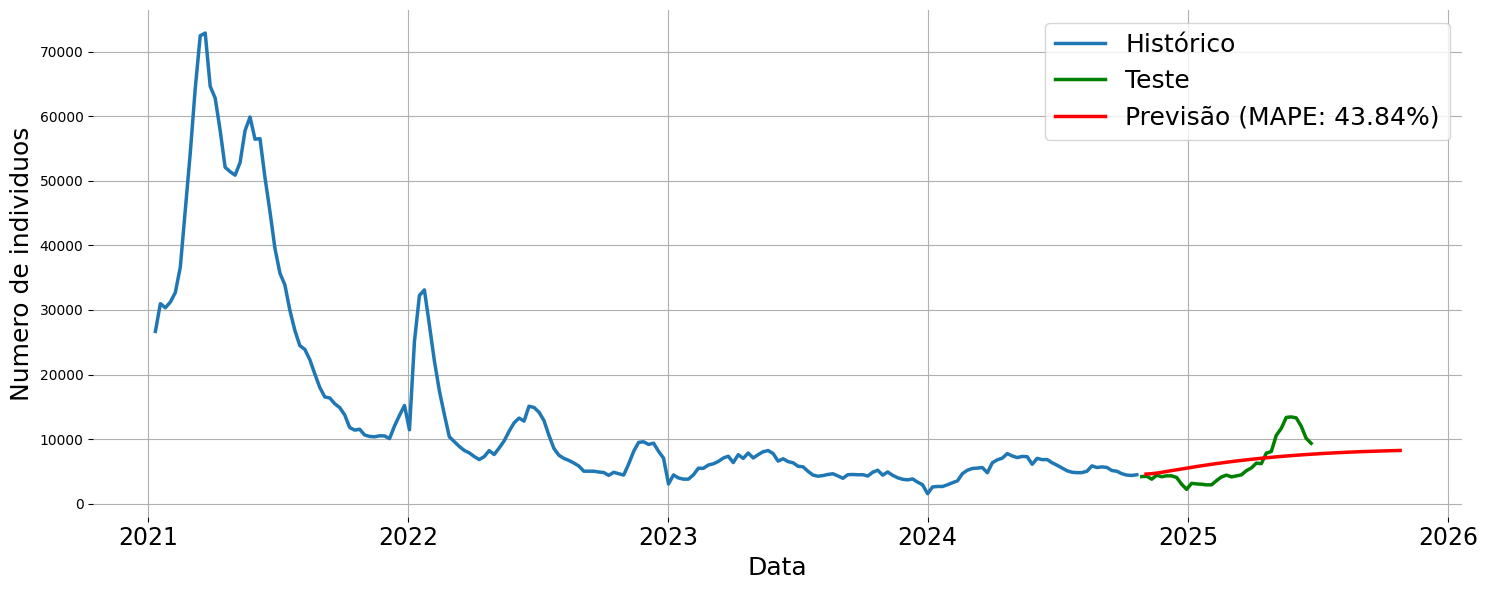

In [55]:
# 3. Plotar com MAPE na legenda
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data["Numero de casos"], label="Histórico", linewidth=2.5)
plt.plot(test_data.index, test_data["Numero de casos"], label="Teste", color="green", linewidth=2.5)
plt.plot(df_future["Data"], df_future["Previsao de casos"],
         label=f"Previsão (MAPE: {mape_val:.2f}%)", color="red", linewidth=2.5)
plt.xlabel("Data", fontsize=18)
plt.ylabel("Numero de individuos", fontsize=18)
# plt.title("Intervalo de confiança")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend(fontsize=18)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
train_data.to_csv("train_data_lstm.csv", index=True)
test_data.to_csv("test_data_lstm.csv", index=True)
df_future.to_csv("df_future_lstm.csv", index=False)